# From Regression to Classification

## Learning Objectives:

- Identify the utility of converting regression tasks to classification tasks.
- To thoughtfully determine the target class.
- To explain classification feature importances.

## Moving From Regression to Classification
- Previously, we've created several regression models to predict the final grade for our students.
- We saw that once we removed G1 and G2 grades, it became much more difficult to predict their final score.
- Since we cannot trust our models' predictions, we cannot trust the insights/explanations we extract from the model.
- Our stakeholder's goal is to identify at-risk students before their final grade in order to intervene and provide additional support to those students. The stakeholder never said that they need to know the EXACT GRADE for each student.
- In this situation, it makes perfect sense to convert this task into a classification that better addresses our stakeholder business case.

## Custom Functions
We've included several functions in the previous lessons this week that we will be using in this analysis. To save space, the function definitions have been removed from this lesson. 

Revisit the previous lessons for the code that corresponds to the following custom functions:

- get_importances (from the Feature Importance lesson)
- plot_importances (from the Feature Importance lesson)
- get_color_dict (from Permutation Importance lesson)
- annotate_hbars (from Visualizing Coefficients lesson)
- plot_coeffs (from Visualizing Coefficients lesson)

## Functions

In [3]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [4]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [5]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [6]:
# Functionalizing Annotating Horizontal Bars
def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [7]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [33]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

## Imports

In [8]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set text displays for sklearn
from sklearn import set_config
set_config(display='text')
## Using pd.set_option to display more columns
pd.set_option('display.max_columns',50)

In [9]:
# Plot Styles
import matplotlib.pyplot as plt
import seaborn as sns
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.2}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [11]:
# Preprocessing
## Load in the student performance - Portuguese dataset & display the head and info
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vS6xDKNpWkBBdhZSqepy48bXo55QnRv1Xy6tXTKYzZLMPjZozMfYhHQjAcC8uj9hQ/pub?output=xlsx"
df = pd.read_excel(url,sheet_name='student-por')
df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12


## Rethinking Our Target
- We need to determine what qualifies as an "at-risk" student for our stakeholder?
    - Note: talking to your stakeholder is ALWAYS a good idea when making this choice.
- There are several different ways we could define an at-risk student.
    1) Students in the 30 percentile or lower (the bottom third of students).
    2) Students who fail (receive an F).
    3) Students who receive a D or an F in their final period.
- After talking with our stakeholder, we've agreed that predicting which students will receive an F would be the most effective target.
- First, we must convert the student scores into a letter grade.

## Calculating Letter Grades from G3
- We want to determine which students will receive an F for their G3 score. Right now, we have the grades as values out of 20.
- The school informed us that when they determine letter grades, they:
    - First, convert the raw scores out of 20 into % out of 100.
    - Bin the % grades to determine the letter:
        - 'A': if G3>=90
        - 'B': if G3>= 80 & G3 <90
        - 'C': if G3>= 70 & G3 <80
        - 'D': if G3>= 60 & G3 < 70
        - 'F': if G3 is <60
- Our first task is to convert the G3 scores into %'s.

In [13]:
## convert G3 to a % out of 100
df['G3(%)'] = (df['G3']/20) *100
df['G3(%)'].head()

0    55.0
1    55.0
2    60.0
3    70.0
4    65.0
Name: G3(%), dtype: float64

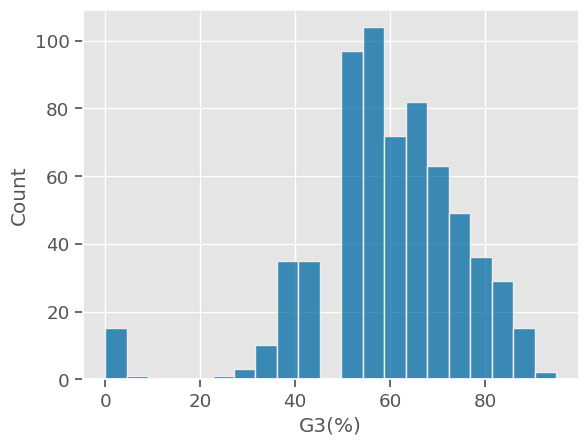

In [14]:
## visual distribution of % grades
ax = sns.histplot(data=df, x='G3(%)')

- Next we need to bin the percentages into letter grades. While there are many ways to do this, one of the most effective is to use panda's cut function.
## Using pd.cut
- Documentation for pd.cut
    - pd.cut is a very flexible function. If we simply knew how many bins we need but don't care about the actual cutoffs for each bin, we can simply provide it an integer for the number of bins.
- For our needs, we will provide a list of the exact bin edges that will be used to cut the data.
    - Note that when we are providing a list of bin edges, we need to provide 1 more value than the # of bins we want to have. - For example, we want to bin the % grades into 5 bins: F,D,C,B,A - In order to create a list of bin edges, the very first value we include is the lowest possible value that is included in the lowest bin. Since we need to account for scores as low as 0, we need to have our first bin edge start at 0. - Next, we define the right edge of the our lowest bin. Since we are binning 0 - 60 as F, the right edge will be 60. - thus far we have used [0,60] to define the left and right edges of our First bin. - For the remainder of the bins, the right edge of the previous bin is also the left edge of the next bin. - Therefore, we only need to add 70 to our bin edges to define our second bin.

In [15]:
## defining bin edges
bins = [0,60,70,80,90,100]
grades = pd.cut(df['G3(%)'], bins=bins)
grades.value_counts().sort_index()

(0, 60]      358
(60, 70]     145
(70, 80]      85
(80, 90]      44
(90, 100]      2
Name: G3(%), dtype: int64

- Looking at the value counts above, we can see the name of the first group is: "(0,60]", the second is "(60,70]" and so on.
    - When displaying intervals/bins, pandas uses square brackets to indicate when the number is INCLUDED in the bin or a round bracket if the number is not included in the bin.
- So in the example above:
    - (0,60]: does not include 0, but does include 60. The logic it is capturing is 0
    - But we want to include 0 in the bin and DON'T want to include 60. We want the logic to be 0<=x<60

There are a couple of ways we can address this:

- We can change this by providing additional arguments to pd.cut:
    - right: "Indicates whether bins includes the rightmost edge or not." default is True.
    - If we say right=False, then the logic will change to match what we wanted, where scores up to 60 (but not 60) are defined as an F.

In [16]:
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts(dropna=False)

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 100)     17
Name: G3(%), dtype: int64

In [17]:
# The downside to this approach is that 100 will no longer be included in the last bin, so we would to increase the final bin edge to 101.
bins = [0,60,70,80,90,101]
grades = pd.cut(df['G3(%)'], bins=bins,right=False)
grades.value_counts()

[0, 60)      301
[60, 70)     154
[70, 80)     112
[80, 90)      65
[90, 101)     17
Name: G3(%), dtype: int64

In [18]:
# Adding Bin labels and saving as a column
## defining bins and their labels
bins = [0,60,70,80,90,101]
bin_labels = ['F','D','C','B','A']
grades = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
grades.value_counts()

F    373
D    145
C     85
B     44
A      2
Name: G3(%), dtype: int64

In [19]:
# Now we can add these values to our DataFrame as a new column 'FinalGrade'.

df['FinalGrade'] = pd.cut(df['G3(%)'],bins, labels=bin_labels,include_lowest=True)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,G3(%),FinalGrade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,4,0,11,11,55.0,F
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,2,9,11,11,55.0,F
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,0,yes,no,no,no,yes,yes,yes,no,4,3,2,2,3,3,6,12,13,12,60.0,F
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,no,yes,yes,yes,yes,yes,3,2,2,1,1,5,0,14,14,14,70.0,D
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,no,no,yes,yes,no,no,4,3,2,1,2,5,0,11,13,13,65.0,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,MS,F,19,R,GT3,T,2,3,services,other,course,mother,1,3,1,no,no,no,yes,no,yes,yes,no,5,4,2,1,2,5,4,10,11,10,50.0,F
645,MS,F,18,U,LE3,T,3,1,teacher,services,course,mother,1,2,0,no,yes,no,no,yes,yes,yes,no,4,3,4,1,1,1,4,15,15,16,80.0,C
646,MS,F,18,U,GT3,T,1,1,other,other,course,mother,2,2,0,no,no,no,yes,yes,yes,no,no,1,1,1,1,1,5,6,11,12,9,45.0,F
647,MS,M,17,U,LE3,T,3,1,services,services,course,mother,2,1,0,no,no,no,no,no,yes,yes,no,2,4,5,3,4,2,6,10,10,10,50.0,F


In [20]:
## We can group by the letter grades and get the min/max of the scores to confirm 
df.groupby('FinalGrade')['G3(%)'].agg(['min','max','count'])

,min,max,count
FinalGrade,,,
F,0.0,60.0,373
D,65.0,70.0,145
C,75.0,80.0,85
B,85.0,90.0,44
A,95.0,95.0,2


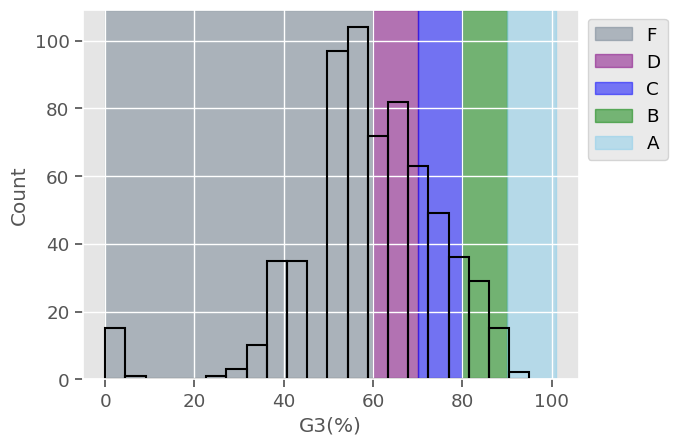

In [21]:
# Next, we will make a visualization showing how our students grades are distributed with color coded regions for each letter grade.

## visualizing the cutoffs for grades
ax = sns.histplot(data=df, x='G3(%)',color='k',fill=False)
colors = ['slategray','purple','blue','green','skyblue']
for i in range(len(bins)-1):
    x1 = bins[i]
    x2 = bins[i+1]
    label = bin_labels[i]
    ax.axvspan(x1,x2, label=label,color=colors[i],zorder=0,alpha=.5)
ax.legend(bbox_to_anchor=[1,1])

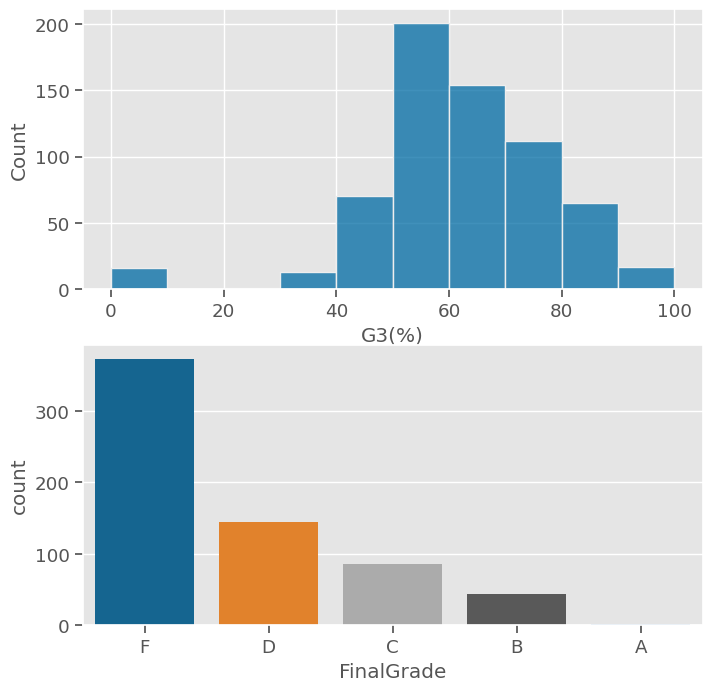

In [22]:
# We can also view these distributions on two separate graphs.

fig, axes = plt.subplots(nrows=2,figsize=(8,8))
sns.histplot(data=df, x='G3(%)',ax=axes[0], binwidth=10);
sns.countplot(data=df,x='FinalGrade',ax=axes[1],order=['F','D','C','B','A']);

## Making Our Final Target & X/y Data
Since we are interested in creating a binary classification. We will define a new column that simply indicates whether a student received an F (failed) or not (passed). We will also check the class balance by using value_counts(normalize=True).

In [23]:
## Define target as had a F or Above
df['target_F'] = df['FinalGrade'] == 'F'
df['target_F'].value_counts(normalize=True)

True     0.57473
False    0.42527
Name: target_F, dtype: float64

## Train Test Split

We must make sure to remove the original target that we used to calculate our grades. Otherwise, G3 and G3% would be perfect predictors of passing or failing!



In [24]:
## Make x and y variables
drop_feats = ['G1','G2','G3','G3(%)','FinalGrade']
y = df['target_F'].copy()
X = df.drop(columns=['target_F',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)

## Preprocessing and Column Transformers

Since we will be revisiting RandomForest first, let's use drop='if_binary' in our OneHotEncoder to keep as many categories as possible without losing information.

In [25]:
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                     fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                           columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                           columns = feature_names, index = X_test.index)
X_test_df.head(3)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
104,15.0,3.0,4.0,1.0,2.0,0.0,5.0,4.0,4.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
284,18.0,2.0,1.0,1.0,1.0,2.0,3.0,2.0,5.0,2.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
579,18.0,1.0,3.0,1.0,1.0,0.0,4.0,3.0,3.0,2.0,3.0,3.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0


## RandomForestClassifier
##### Function for Evaluating Classification Models

In [26]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    
    fig.tight_layout()
    plt.show()
     
    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



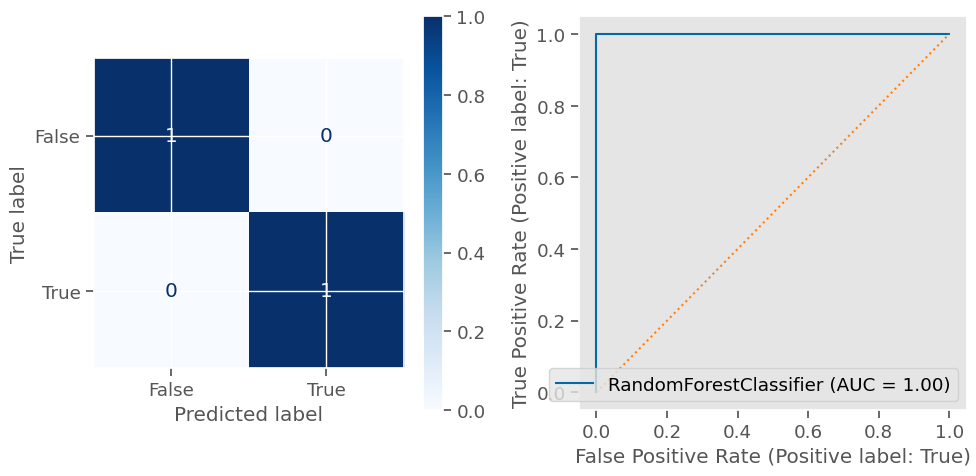

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



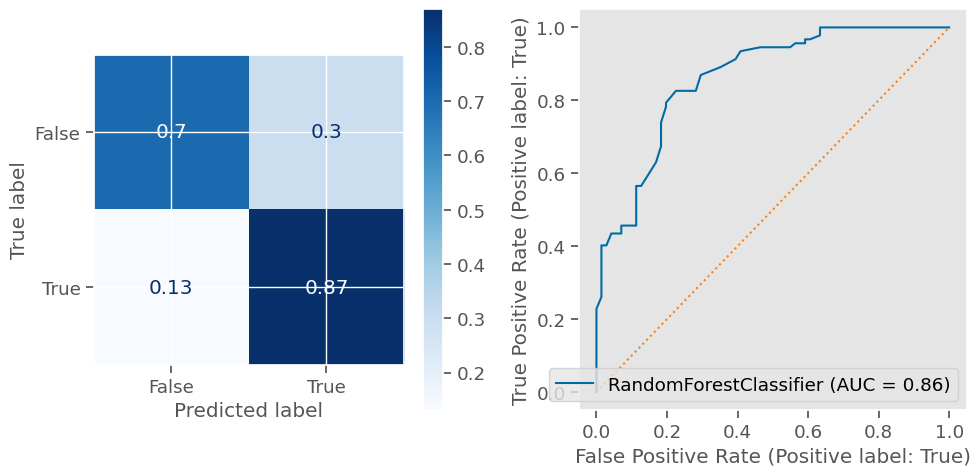

In [27]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()#class_weight='balanced')
rf_clf.fit(X_train_df,y_train)
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

- We have an overall accuracy of .80, which isn't bad. However, our task is to identify the students who will get an F (the True group). So let's take a closer look at our True class scores.
    - The Recall score for True is .87. This means that out of all of the students who will fail, our model is identifying 87% of them correctly. While this isn't perfect (there are still 13% of students who will fail that are falling through the cracks), this is MUCH better than our R-squared of 0.35!
- As we can see above, our classification task is performing much better than our regression version of the task! This is a much more appropriate model to extract insights from.

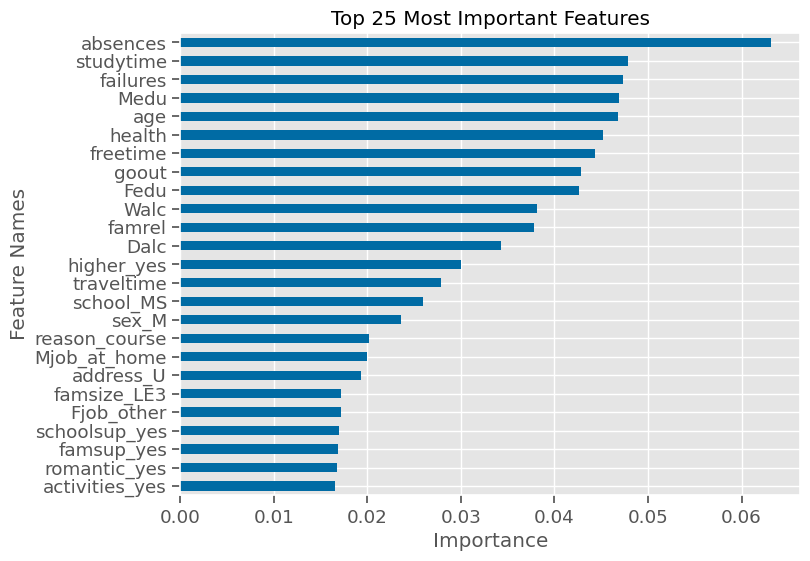

In [28]:
rf_importances = get_importances(rf_clf)
ax = plot_importance(rf_importances,top_n=25)

- As we can see above, absences, studytime, failures, Medu, and age are the most important features, with many other features not too far behind.
- As we discussed previously, built-in feature importances are biased towards considering numeric features as more important, so let's compare these importances to our Permutation Importance.

In [29]:
# Permutation Importances - RandomForest
from sklearn.inspection import permutation_importance
r = permutation_importance(rf_clf,X_train_df,y_train,n_jobs=-1,n_repeats=5)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [30]:
## getting the colors for the top 7 important rf features
colors_rf = get_color_dict(rf_importances,top_n=7)

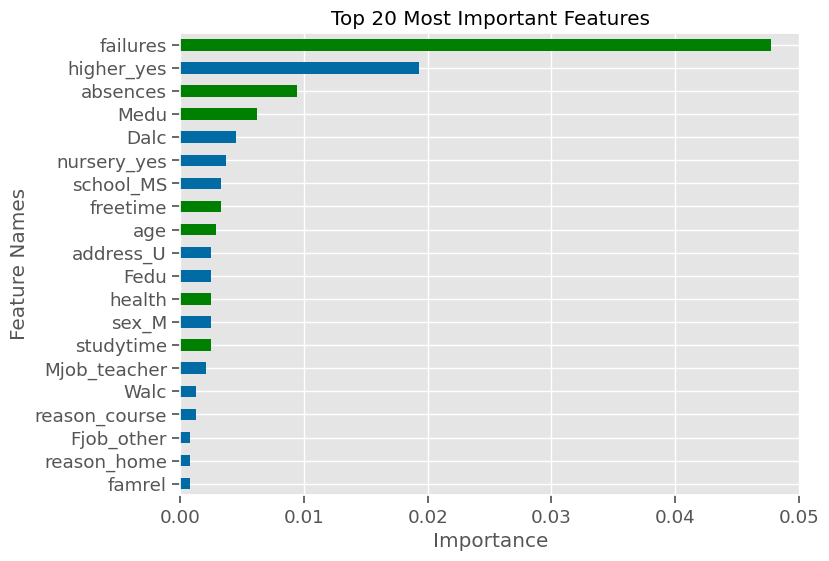

In [34]:
## can make the mean importances into a series
rf_perm_importances = pd.Series(r['importances_mean'],index=X_train_df.columns,
                           name = 'permutation importance')
rf_perm_importances = rf_perm_importances.sort_values(ascending=False)
plot_importance_color(rf_perm_importances,color_dict=colors_rf,top_n=20);

- As we can see above, one of the features with the top 3 largest permutation importance were not in the random forest's top features:
    - higher_yes
- As we previously discussed, built-in feature importance often overlooks categorical features. Our permutation importance, however, avoids this bias and it determined 1 out of the 3 most important features to be a categorical feature.
- Also, as we discussed previously, neither feature importance nor permutation importance tells us the directionality of that feature vs the target.
    - higher_yes means that the student is planning to pursue higher education. We may suspect that being in this group leads to decreased likelihood of Failing, but we cannot say that for sure with just this information.

## Post-Modeling EDA
- Let's combine all of our processed data back into 1 DataFrame for our final EDA.
    - This means we want to combine:
        - X_train and y_train (first),
        - X_test and y_test (second),
        - and then combine both of the above!

In [37]:
# Combining all data for eda post-modeling
plot_df_train = pd.concat([X_train_df, y_train],axis=1)
plot_df_test = pd.concat([X_test_df, y_test],axis=1)
plot_df = pd.concat([plot_df_train, plot_df_test])
plot_df

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes,target_F
54,15.0,3.0,3.0,1.0,1.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
208,16.0,2.0,3.0,2.0,1.0,0.0,5.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
23,16.0,2.0,2.0,2.0,2.0,0.0,5.0,4.0,4.0,2.0,4.0,5.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,True
547,16.0,4.0,1.0,1.0,1.0,0.0,4.0,1.0,2.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,True
604,18.0,1.0,1.0,3.0,2.0,1.0,4.0,4.0,2.0,1.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,17.0,1.0,1.0,1.0,3.0,0.0,4.0,3.0,3.0,1.0,1.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,False
454,16.0,1.0,2.0,1.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,4.0,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,True
56,15.0,4.0,3.0,1.0,2.0,0.0,4.0,3.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
203,17.0,1.0,2.0,1.0,2.0,0.0,3.0,1.0,3.0,1.0,5.0,3.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,True


Now, let's do some quick exploration of the relationship between our target and the top 3 features.

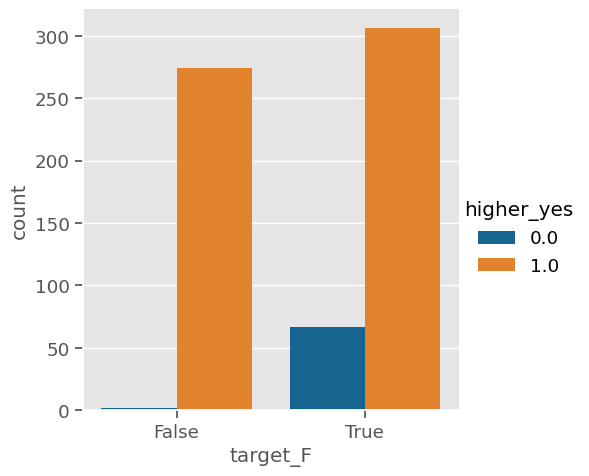

In [38]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='higher_yes');


As we can see with our EDA above, it looks like there are a higher proportion of students that are NOT pursuing higher education (blue group) in the Failing students (target_F==True) than the successful students.

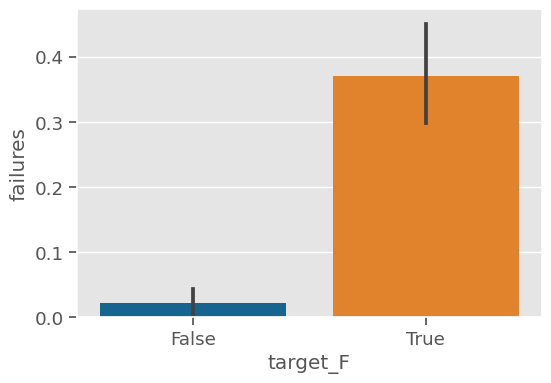

In [39]:
plt.figure(figsize=(6,4))
ax = sns.barplot(data=plot_df, x='target_F',y='failures')

We can see above that students who failed Portuguese had many more failures, on average.

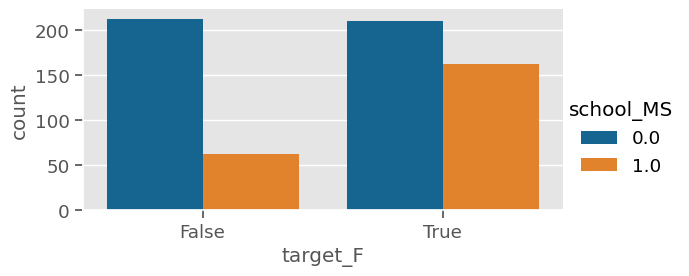

In [40]:
sns.catplot(data=plot_df, kind='count', x='target_F', hue='school_MS',
            aspect=2, height=3);

## Summary
In this lesson you converted a regression target to classification target. This may or may not be appropriate depending on your stakeholder's needs. In this case, the classification model served our purpose and allowed us to develop a higher performing model from which to gain insights. Now that we are working with a classification task, we will revisit regression coefficients in the next lesson, but this time it will be for Logistic Regression coefficients for classification.

# Logistic Regression Coefficients
## Learning Objectives:

- Extract and visualize coefficients from sklearn logistic regression model.
- Compare feature importance vs regression coefficients.
- Convert log odds to odds and interpret each.

## Introduction
- Just like Linear Regression models calculate a coefficient for each feature to predicted a value for the target, Logistic Regression models also calculate coefficients to predict the probability of being in a specific class.
- It does this by converting a linear regression equation into a sigmoid curve, which will convert the predictions for y to a value between 0 and 1.

## Converting Our Linear Equation to A Sigmoid Curve
- Remember our multiple linear regression equation:

where: n = the number of features

It can be summarized as:

By taking this equation and moving it to the denominator, we can restrict our output to values between 0 and 1.

Visual Example of Converting Linear Equation to a Sigmoid Curve Desmos Example


Let's look at example of an arbitrary linear equation:


Here we define a simple function to solve this equation when various values of x are given.

In [41]:
def calc_lin_reg(x):
    return x*2.713 - .8

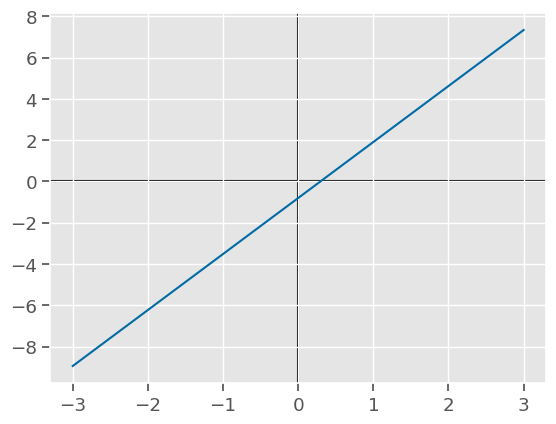

In [42]:
xs = np.linspace(-3,3)
ys = calc_lin_reg(xs)
def plot_xy(xs,ys):
    plt.plot(xs,ys)
    plt.axvline(0,color='k', zorder=0)
    plt.axhline(0, color='k', zorder=0)
plot_xy(xs,ys)

You can see that a linear equation will give unbounded results which is why it is used for predicting a continuous variable.

For classification, we want to bound our results.

Notice the location of our example linear equation within the logistic equation below:


We will write this equation into our code and plot the result.

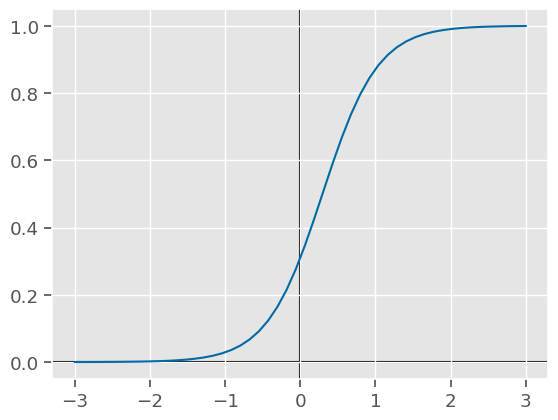

In [43]:
from math import e
def calc_sigmoid(ys):
    return 1/(1+e**-ys)
ys_sigmoid = calc_sigmoid(ys)
plot_xy(xs,ys_sigmoid)

Now the regression equation is predicting a value between 0 and 1 which represents the probability of being in the 1 class. By default, values above .5 will be classified as 1 while values below .5 will be classified as 0.
## LogisticRegression in sklearn

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       0.73      0.71      0.72       205
        True       0.79      0.81      0.80       281

    accuracy                           0.77       486
   macro avg       0.76      0.76      0.76       486
weighted avg       0.76      0.77      0.76       486



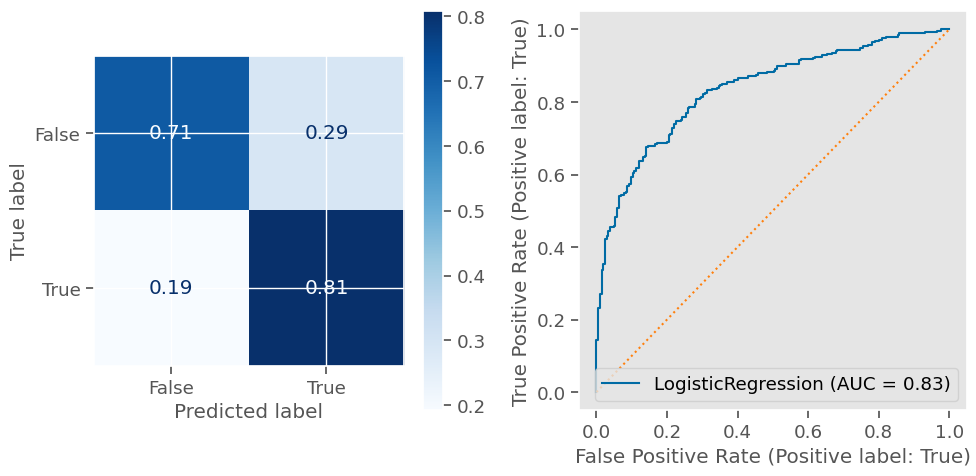

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.73      0.69      0.71        71
        True       0.77      0.80      0.79        92

    accuracy                           0.75       163
   macro avg       0.75      0.75      0.75       163
weighted avg       0.75      0.75      0.75       163



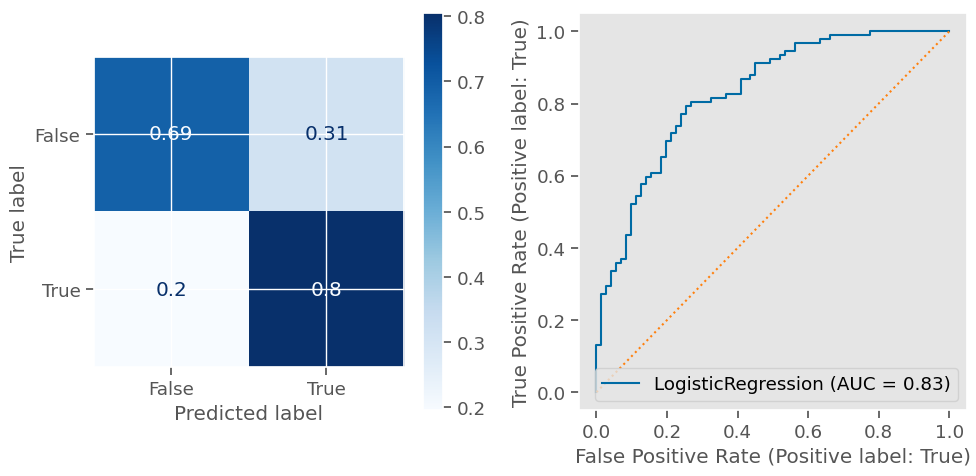

In [44]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_df, y_train)
evaluate_classification(logreg,X_train_df,y_train, X_test_df,y_test)

- As we can see above, our LogisticRegression model did not perform quite as well as our RandomForest, but it is still performing well-enough that it is worth extracting our coefficients and getting additional insights into the directionality of the effect of each feature on the target.

## Extracting Coefficients from LogisticRegression in scikit-learn
- Just like we extracted our coefficients from our linear regression's lin_reg.coef_, we can also extract our logistic regression coefficients in the same way.
- Both scikit-learn Linear Regressions & Logistic Regressions calculate coefficients.
    - However, logistic regression models will return more than 1 set of coefficients if you are predicting more than 2 classes.
- Let's try to use our previous get_coeffs function on the logistic regression model.

In [45]:
try:
    get_coeffs_linreg(logreg)
except Exception as e:
    print("ERROR: ", e) 

ERROR:  name 'get_coeffs_linreg' is not defined


- We got an error when we tried to make our coef's into a pd.Series. The reason for this is that we have an extra empty matrix around our coefficients.
- Notice the shape of our .coef_ below has an extra first dimension added:

In [46]:
logreg.coef_

array([[-0.22006835, -0.18656296, -0.2154208 , -0.33705263, -0.37135291,
         1.39712192, -0.25645027,  0.10196875,  0.12237896,  0.43143587,
        -0.11748189,  0.13292964,  0.07234671,  0.62777626,  0.61205642,
        -0.32462958,  0.13820367,  0.19625127,  0.41638756, -0.35115234,
        -0.19710749,  0.01675313,  0.11514691, -0.30292436,  0.38010115,
         0.32620578,  0.29062611, -0.69398091,  0.16758475, -0.38941297,
         0.21961627,  0.00223972, -0.14276047, -0.05446664,  0.19725488,
         0.94179001,  0.13862419,  0.1247438 , -0.18637901, -0.07942583,
        -1.70464204, -0.07350188,  0.19208352]])

In [47]:
# Also note that the intercept_ (which was a single value in LinearRegression mode) is now also wrapped in an array.
logreg.intercept_

array([6.26535316])

## Slicing LogReg Coefficients
- The first dimension is unnecessary, as all of our coefficients are stored in the first (and only) index of the first dimension.

In [48]:
logreg.coef_[0]

array([-0.22006835, -0.18656296, -0.2154208 , -0.33705263, -0.37135291,
        1.39712192, -0.25645027,  0.10196875,  0.12237896,  0.43143587,
       -0.11748189,  0.13292964,  0.07234671,  0.62777626,  0.61205642,
       -0.32462958,  0.13820367,  0.19625127,  0.41638756, -0.35115234,
       -0.19710749,  0.01675313,  0.11514691, -0.30292436,  0.38010115,
        0.32620578,  0.29062611, -0.69398091,  0.16758475, -0.38941297,
        0.21961627,  0.00223972, -0.14276047, -0.05446664,  0.19725488,
        0.94179001,  0.13862419,  0.1247438 , -0.18637901, -0.07942583,
       -1.70464204, -0.07350188,  0.19208352])

In [49]:
logreg.intercept_[0]

6.265353163162884

- If we were predicting more than 2 classes, we would have a dimension for each class.
    - In this case, we would need to decide WHICH target class we wanted to extract the coefficients for and slice out the correct index.
## Writing a get_coeffs_logreg function.
- Let's define a new get_coeffs_logreg function that we can use for LogisticRegression models.
    - It will be structured very similarly to our previous function, but this time we will slice out the correct index from our .coef_ and our .intercept_.
    - Since we are focusing on a binary task, let's use 0 as the default value for the class index.

In [50]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0):
    if feature_names is None:
        feature_names = logreg.feature_names_in_ 
    
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)  
    return coeffs

In [51]:
coeffs = get_coeffs_logreg(logreg)
coeffs

higher_yes          -1.704642
Fjob_teacher        -0.693981
reason_home         -0.389413
studytime           -0.371353
Mjob_health         -0.351152
traveltime          -0.337053
address_U           -0.324630
Fjob_at_home        -0.302924
famrel              -0.256450
age                 -0.220068
Fedu                -0.215421
Mjob_other          -0.197107
Medu                -0.186563
activities_yes      -0.186379
guardian_father     -0.142760
Walc                -0.117482
nursery_yes         -0.079426
internet_yes        -0.073502
guardian_mother     -0.054467
reason_reputation    0.002240
Mjob_services        0.016753
absences             0.072347
freetime             0.101969
Mjob_teacher         0.115147
goout                0.122379
paid_yes             0.124744
health               0.132930
famsize_LE3          0.138204
famsup_yes           0.138624
reason_course        0.167585
romantic_yes         0.192084
Pstatus_T            0.196251
guardian_other       0.197255
reason_oth

- There we go! We have our new get_coeffs function designed explicitly for logistic regression.
    - Note: an even better solution would be to make a get_coeffs function that is flexible enough to work for either type of regression! We won't cover this in our lessons, but if you write a function that does this, share it with your cohort on Discord!
## Visualizing Our Coefficients
- We previously wrote a plot_coeffs function that should already work with our logistic regression coefficients, now that we have them in a Series.
- Let's test and confirm that it works!

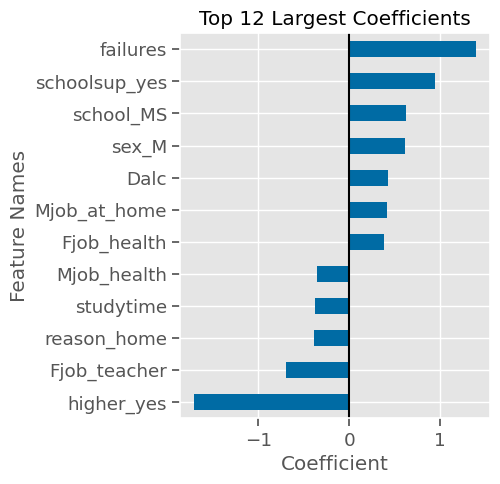

In [52]:
ax = plot_coeffs(coeffs,top_n=12)

- Excellent! Now let's explain what our coefficients are telling us

## Comparing Linear and Logistic Regression Coefficients
Brief review of linear regression coefficients

- Previously, when we interpreted the coefficients of our linear regression, we said that the coefficient for a feature represents how much our target will change for every increase of 1 unit in our feature.
- E.g. For each failure, the final grade decreased by 1.295.
- For OneHotEncoded features, increasing the value of that feature by 1 really meant how being in that category affected the target.
    - E.g. Intending to go to college (higher_yes ==1) increased the final grade by 1.695.
    
Introducing logistic regression coefficients

- But now that our target is a classification, how do we interpret the meaning of logistic regression coefficients?
- At the start of the lesson, we discussed how logistic regression converts a linear regression equation into an S-shaped (sigmoid) curve. We said the result is that the curve predicts a probability value between 0 and 1 instead of the actual score.
- The coefficients of a logistic regression are the log odds, which we will convert to odds for interpretation and discuss in detail below.

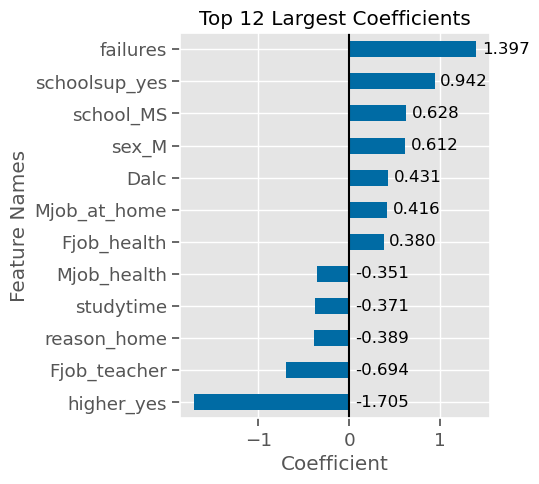

In [55]:
ax = plot_coeffs(coeffs,top_n=12)
annotate_hbars(ax)

- In our figure above, we have both positive and negative coefficients.
    - Positive values indicate the feature makes it more likely the student will fail (class==True)
    - Negative values indicate the feature makes it less likely the student will fail.
- If you look closely, we actually have some values that are larger than +1 or less than -1. But we said that logistic regression returns a probability less than 1?
    - So what is going on? What are these coefficient values?

## LogisticRegression Returns Log Odds Coefficents
"...logistic regression coefficients represent the log odds that an observation is in the target \class (“1”) given the values of its X variables. Thus, these log odd coefficients need to be converted to regular odds in order to make sense of them. Happily, this is done by simply exponentiating the log odds coefficients, which you can do with np.exp()" - Source: Medium Blog Post on Interpreting Linear Regression and Logistic Regression Coefficients
- In order for us to explain the logistic regression coefficients in plain English, we first need to convert the log-odds into odds.

## Converting Log-Odds to Odds
- To convert our log-odds coefficients into odds, we need to take the Euler number (the math constant e = 2.718281) and raise it to the power of our coefficient (e**coeff).

In [56]:
## logodds coeff for failures
coeffs.loc['failures']

1.397121922436006

In [57]:
## Raising e to the power of our logodds coeff 
import math
math.e**coeffs.loc['failures']

4.043545565982182

- This returns the "odds" of being in the positive class (in our case - the odds of failing vs passing).
- By using np.exp(), we can do this to our entire series at once:

<AxesSubplot: title={'center': 'All Coefficients - Ranked by Magnitude'}, xlabel='Coefficient', ylabel='Feature Names'>

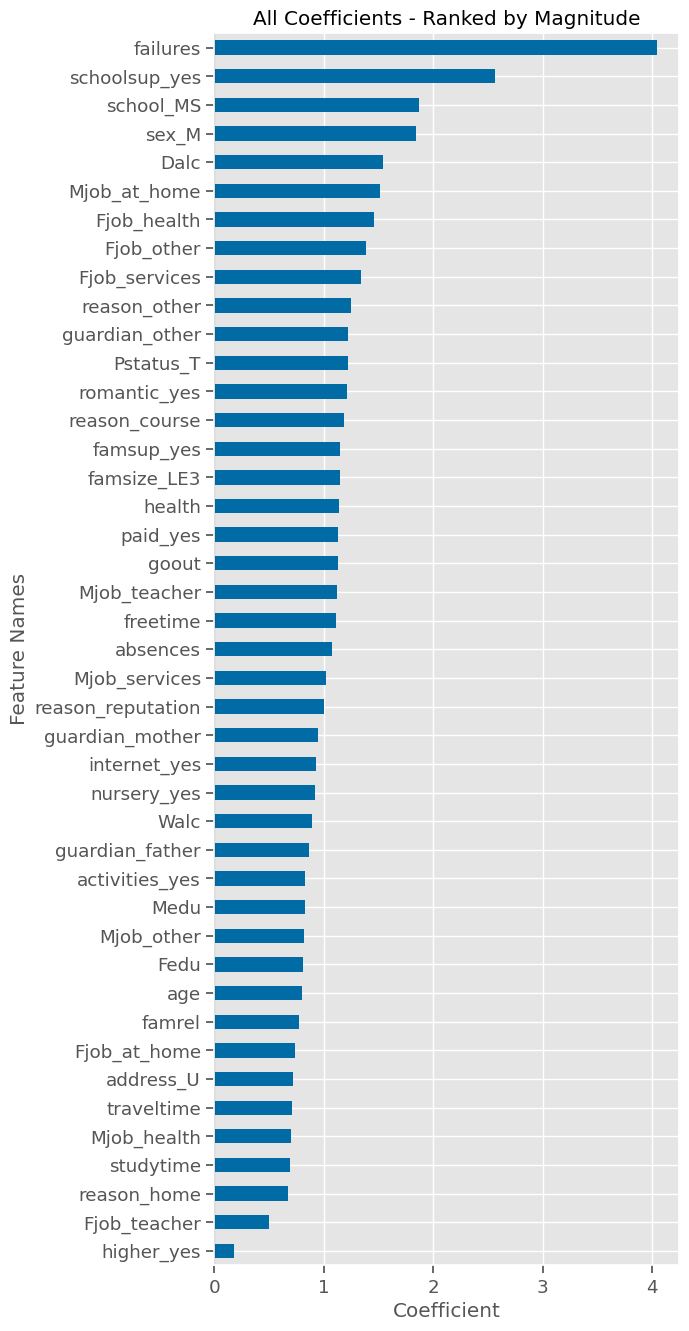

In [61]:
coeffs_odds = np.exp(coeffs)
plot_coeffs(coeffs_odds, figsize=(6,16))

## Updating our function
- Let's add a boolean argument for if we want to convert the log-odds into odds right away.

In [64]:
def get_coeffs_logreg(logreg, feature_names = None, sort=True,ascending=True,
                      name='LogReg Coefficients', class_index=0, 
                      as_odds=False):
    
    if feature_names is None:
        feature_names = logreg.feature_names_in_
        
    ## Saving the coefficients
    coeffs = pd.Series(logreg.coef_[class_index],
                       index= feature_names, name=name)
    
    # use .loc to add the intercept to the series
    coeffs.loc['intercept'] = logreg.intercept_[class_index]
        
    if as_odds==True:
        coeffs = np.exp(coeffs)
    if sort == True:
        coeffs = coeffs.sort_values(ascending=ascending)
    
        
    return coeffs

In [66]:
coeffs_odds = get_coeffs_logreg(logreg,  as_odds=True)
coeffs_odds

higher_yes             0.181837
Fjob_teacher           0.499583
reason_home            0.677454
studytime              0.689800
Mjob_health            0.703877
traveltime             0.713871
address_U              0.722795
Fjob_at_home           0.738655
famrel                 0.773793
age                    0.802464
Fedu                   0.806202
Mjob_other             0.821102
Medu                   0.829806
activities_yes         0.829959
guardian_father        0.866962
Walc                   0.889157
nursery_yes            0.923647
internet_yes           0.929134
guardian_mother        0.946990
reason_reputation      1.002242
Mjob_services          1.016894
absences               1.075028
freetime               1.107349
Mjob_teacher           1.122038
goout                  1.130182
paid_yes               1.132858
health                 1.142170
famsize_LE3            1.148209
famsup_yes             1.148692
reason_course          1.182446
romantic_yes           1.211772
Pstatus_

## Interpreting Odds
- Odds are how much more likely to fall into the 1 class than the 0 class.
    - - A value of 1 means both classes are equally likely.
    - - A value > 1 means that the 1 class is more likely than the 0 class.
    - - A value < 1 means that the 1 class is less likely than the 0 class.
- You've likely encountered odds in real world situations/conversations.
    - "What are the odds that horse A will win the race over horse B?"
    - In other words, how many times more likely is horse A to win vs horse B?

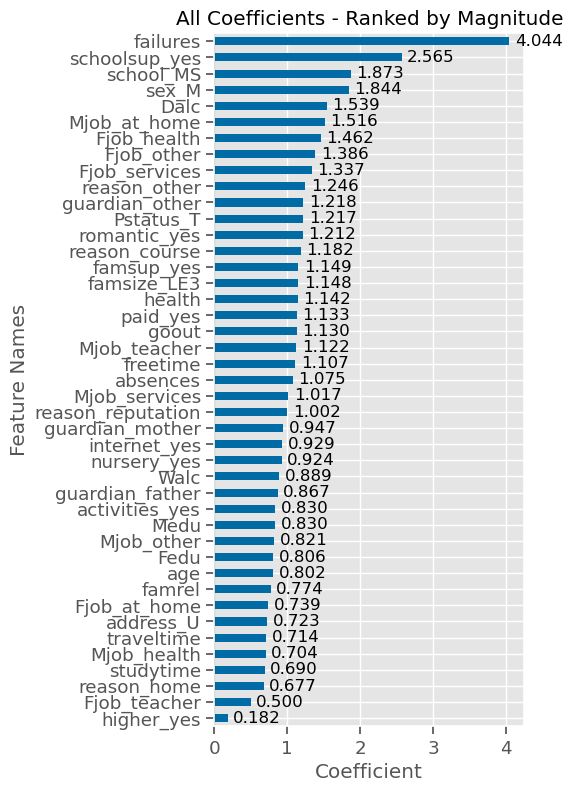

In [70]:
coeffs_odds = get_coeffs_logreg(logreg, as_odds=True)
ax = plot_coeffs(coeffs_odds,figsize=(4,9))
annotate_hbars(ax)

## Interpreting Odds Coefficients
“For every one-unit increase in [X variable], the odds that the observation is in (y class) are [coefficient] times as large as the odds that the observation is not in (y class) (when all other variables are held constant).”
- Let's walk through interpreting some of our largest odds coefficients:
    - failures:
        - For every additional failure, the odds of a student failing is 4.043 times the odds of passing.
    - schoolsup_yes:
        - Getting (needing?) extra support from the school increases the odds of failing by 2.566
    - school_MS:
        - students who attend MS (and not GP) are 1.873 times more likely to fail.
    - sex_M:
        - male students are 1.844 times more likely to fail than female students.

### Note About Odds being Positive

Now that we have odds coefficients, we no longer have any negative values.
- This means that any of our negative log-odds coefficients (that decreased the chances of the failing) are now odds values less than 1.
- In other words, we can no longer use the magnitude of the coefficients to determine the most impactful, since a very small coefficient will still represent a big change.

Looking back at our smallest odds coefficients, we can see that:
- higher_yes:
    - students who intended to pursue higher education are .18 times more likely to fail (meaning they are much less likely to fail).
    - Or we could say that these students are .18 times less likely to fail.
- Fjob_teacher:
    - having a father who is a teacher decreases the odds of failing by .5.
- reason_home:
    - attending the school because its close to their home decreases the odds of failing by .678 times.

## Presenting Logistic Regression Coefficients to Non-Technical Stakeholders
- To help us digest and interpret the coefficients better, let's add a vertical line at 1 (where 1= equally likely of Failing or Passing).


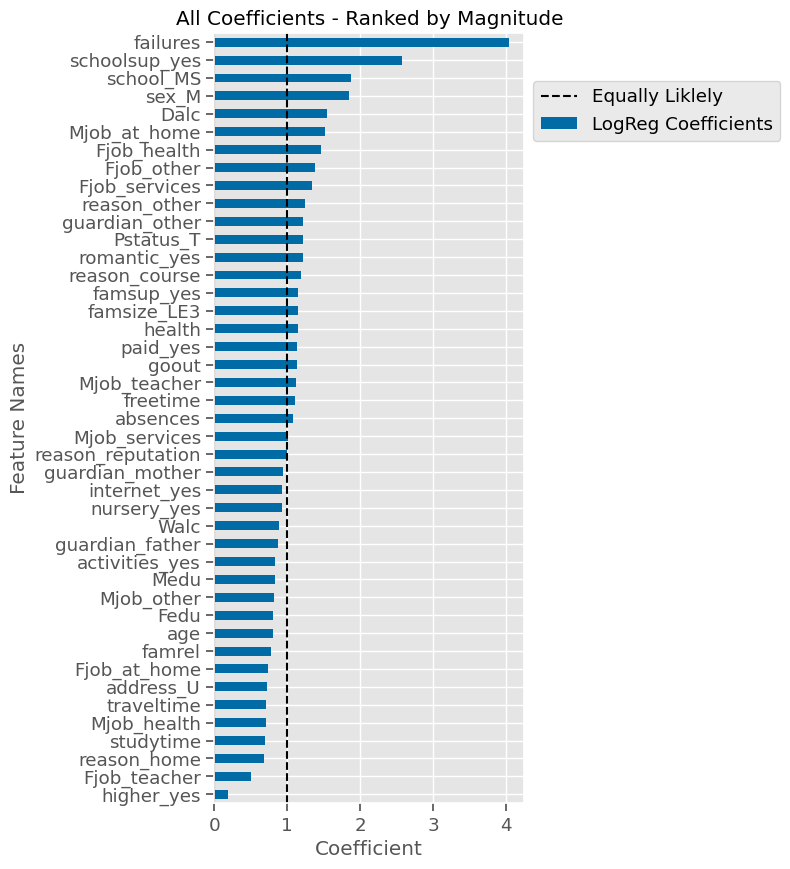

In [71]:
ax = plot_coeffs(coeffs_odds,figsize=(4,10))
ax.axvline(1, ls='--',label='Equally Liklely',color='k', zorder=1)
ax.legend(bbox_to_anchor=[1,.95])



# annotate_hbars(ax)

- When presenting a summary of your model's findings to a non-technical stakeholder, you can choose which version of the coefficients you show.
- Depending on your comfort level for interpreting odds, you may want to leave the coefficients as log-odds to get a nice/clean positive value for each feature.

## Visualizing Odds Coefficients more effectively.
- If you are comfortable explaining odds and use color-coding and/or a vertical line indicating the threshold between more/less likely, then using odds coefficients may work better for you.
- To aid in the visual interpretation of Odds, we can color-code the values greater than 1 and less than 1.
- See the next (optional) lesson for how to accomplish this yourself!

## Summary
- In this lesson, we reviewed the extraction and interpretation of Logistic Regression coefficients.
- The Logistic Regression coefficients provided more information about the directionality of the relationship between our features and our target.
    - However, our Logistic Regression did not perform as well as our RandomForest model.
- It would be great if we had a tool that would allow us to get the directionality of the features effect on our model's predictions for all models, not just Logistic Regression model.
    - There is indeed such a tool! Which we will explore in the next lesson.
    
## Additional Resources
- If you'd like a better understanding of why log-odds are used in machine learning check out:
    - StackExchange: Why use [log]odds instead of probability in logistic regression?
    https://stats.stackexchange.com/questions/215349/why-use-odds-and-not-probability-in-logistic-regression#:~:text=The%20logarithm%20of%20an%20odds,t%20lead%20to%20impossible%20predictions.
- For an intuitive explanation of logs/logarithms, check out the following videos:
    - StatQuest: Logs (logarithms), Clearly Explained!!!
    https://www.youtube.com/watch?v=VSi0Z04fWj0
    - StatQuest: Odds and Log(Odds), Clearly Explained!!!
    https://www.youtube.com/watch?v=ARfXDSkQf1Y
    - StatQuest:Odds Ratios and - Log(Odds ratios), Clearly Explained!!!
    https://www.youtube.com/watch?v=8nm0G-1uJzA


# (Optional) Advanced MatPlotLib
## Learning Objectives:

By the end of this lesson, students will be able to:

- Color matplotlib bars based on values
- Manually construct a matplotlib legend
- Annotate matplotlib figures

## Color-Coding By Value
In order to create the bar graph from the previous lesson, with the bars colored by value, we created a dictionary that contains each feature name as the key and the color to use for its bars, based upon if the value was greater or less than 1. 

In [74]:
# We accomplished this using the following loop:

colors_dict = {}
for i in coeffs_odds.index:
    rounded_coeff = np.round( coeffs_odds.loc[i],3)
    if rounded_coeff < 1:
        color = 'darkred'
    
    elif rounded_coeff> 1:
        color = 'forestgreen'
    else:
        color='gray'
    colors_dict[i] = color
        
## previewing example >1 and <1
colors_dict['age'],colors_dict['higher_yes']

('darkred', 'darkred')

We will now convert this code into a function, but we will add some flexibility.

To use this function for positive/negative or other value comparisons:
- Let's add an argument called threshold that will be 1 by default, but will be the value compared to determine the color.
- Let's also turn the 3 colors into keyword arguments in case we want to change them.

In [86]:
def get_colors_gt_lt(coeffs, threshold=1, color_lt ='darkred',
                     color_gt='forestgreen', color_else='gray'):
    """Creates a dictionary of features:colors based on if value is > or < threshold"""
    colors_dict = {}
    for i in coeffs.index:
        rounded_coeff = np.round( coeffs.loc[i],3)
        if rounded_coeff < threshold:
            color = color_lt
        elif rounded_coeff > threshold:
            color = color_gt
        else:
            color=color_else
        colors_dict[i] = color
    return colors_dict

In [99]:
def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), color_dict=None,plot_kws = {}):
    if top_n is None:
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"
    else:
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients" 
    if color_dict is not None:
        colors = plot_vals.index.map(color_dict)
        plot_kws = update({'color':colors})

    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient',ylabel='Feature Names', title=title)   
    return ax

def plot_coeffs_color(coeffs, top_n=None,  figsize=(8,6), color_dict=None,
                   plot_kws = {} ):
        """Plots series of coefficients
        Args:
        ceoffs (pands Series): importance values to plot
        top_n (int): The # of features to display (Default=None).
                         If None, display all.
                        otherwise display top_n most important
                         
        figsize (tuple): figsize tuple for .plot
        color_dict (dict): dict with index values as keys with color to use as vals
                            Uses series.index.map(color_dict).
        plot_kws (dict): additional keyword args accepted by panda's .plot
         
        Returns:
        Axis: matplotlib axis
        """
    # sorting with asc=false for correct order of bars
    if top_n is None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients" 
         ## plotting top N importances
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        plot_kws = update({'color':colors})
    
    
    ax = plot_vals.plot(kind='barh', figsize=figsize,**plot_kws)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [103]:
colors_odds = get_colors_gt_lt(coeffs_odds,threshold=1)
ax = plot_coeffs_color(coeffs_odds,color_dict=colors_odds,figsize=(8,12))
ax.axvline(1, ls='--',label='Equal Likelihood',color='k',
          zorder=1)
ax.legend();

NameError: name 'update' is not defined

This entire section is janked up

# SHAP Model Explainers - Global
## Learning Objectives:

- Use SHAP to produce global explanations of a model
- Visualize and interpret SHAP summary plots

## What is SHAP?
SHAP is a tool used to aid in model interpretations. SHAP deconstructs the model, and tells us why the model made each prediction.

- SHAP (SHapley Additive exPlanations))
    - Repository
    - Documentation
- SHAP is a package that leverages game theory and the idea of marginal contributions to determine how each feature affects the model's predictions. You can think of this as how different players impact the success of a team (or how features impact the prediction of the model).
- The SHAP package will use your model to iteratively remove features from the data set and evaluate the change in the model's predictions.
- The result of this process is a set of Shapley values (or SHAP values).
- The SHAP value is a calculation of the relative contribution of each feature toward the prediction.
- SHAP will produce what is called a global explanation. In other words, it will explain how the model made its predictions for the entire dataset. (In an upcoming lesson, we will explore local explanations, which are explanations about a single row/observation).
- For more details about the inner workings of the SHAP package, see the white papers and articles linked at the bottom of this page.

## Explaining Our Model
- We will be using our random forest model from the lesson "From Regression to Classification." Let's remind ourselves of its performance and feature importances.

--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       205
        True       1.00      1.00      1.00       281

    accuracy                           1.00       486
   macro avg       1.00      1.00      1.00       486
weighted avg       1.00      1.00      1.00       486



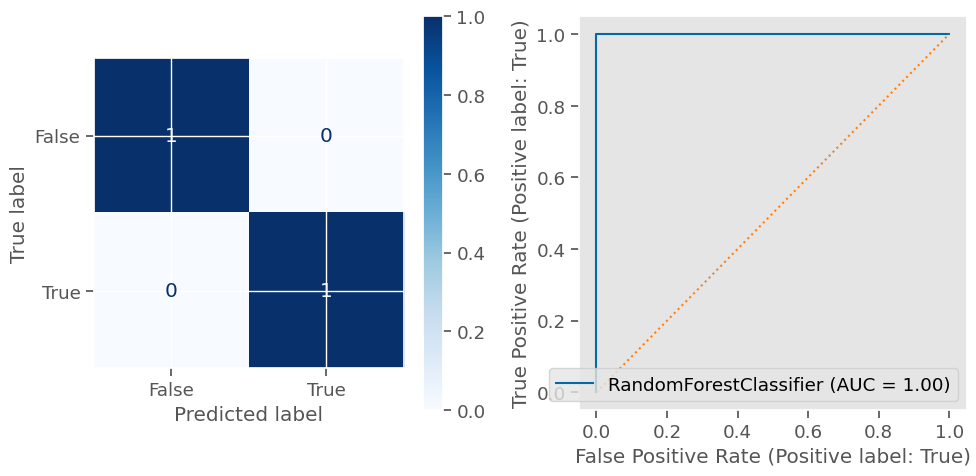

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

       False       0.81      0.70      0.75        71
        True       0.79      0.87      0.83        92

    accuracy                           0.80       163
   macro avg       0.80      0.79      0.79       163
weighted avg       0.80      0.80      0.80       163



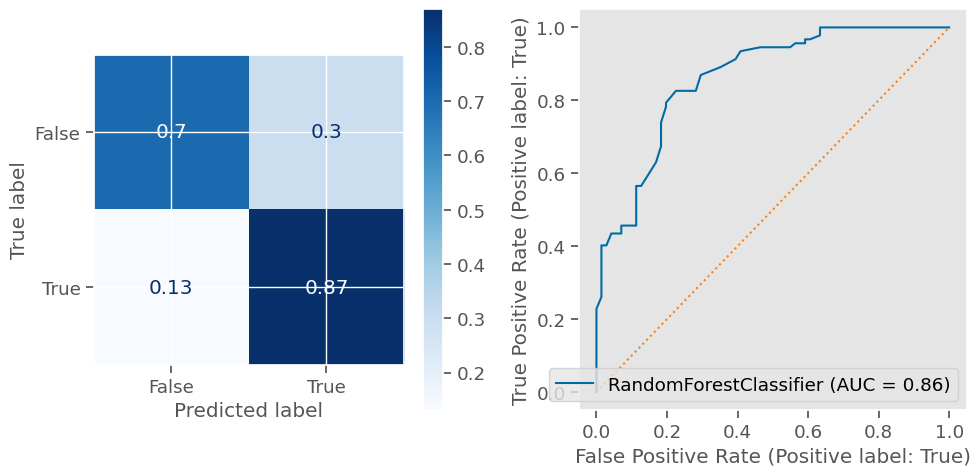

In [104]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

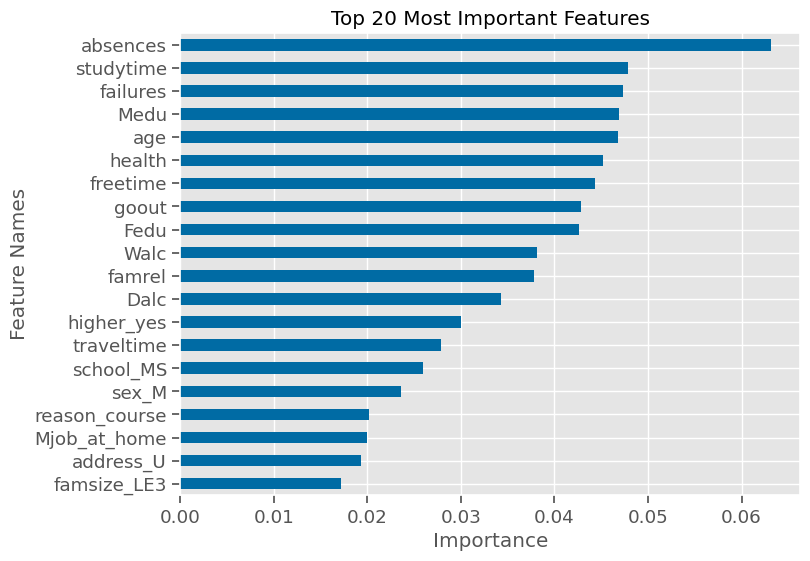

In [105]:
rf_importances = get_importances(rf_clf)
plot_importance(rf_importances,top_n=20);

In [107]:
## How To Use Shap
# There are several SHAP plots that are interactive and require javascript to be loaded. We can do this via the initjs() function in SHAP.
# Import shap and initialize javascript:
import shap
shap.initjs()

## SHAP Explainers
- In order to calculate our SHAP values for our model & features, we will need to create an instance of a Model Explainer.
- Explainer objects will need the model and some X and y data.

## Preparing Data for Shap
- Shap's approach to explaining models can be very resource-intensive for complex models such as our RandomForest.
- To get around this issue, shap includes a convenient sampling function to save a small sample from X_train.
- If we check the length of our X data, we can see how many rows we have.

In [108]:
len(X_train_df)

486

- 486 may be fine, or it could be a bit much for your local machine.
- Whenever the dataset is too large for your machine to process in a timely manner, we can use SHAP's utility for sampling a subset of our data (shap.sample).
- Let's take just 400 observations from our X_train_df and save it as X_shap.

In [109]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
473,16.0,2.0,1.0,2.0,1.0,0.0,2.0,4.0,3.0,2.0,3.0,4.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
340,17.0,3.0,3.0,1.0,1.0,0.0,4.0,4.0,3.0,1.0,3.0,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
452,16.0,2.0,2.0,3.0,2.0,0.0,4.0,4.0,5.0,1.0,1.0,4.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
555,16.0,1.0,2.0,1.0,3.0,0.0,4.0,3.0,4.0,1.0,1.0,3.0,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
70,16.0,3.0,1.0,2.0,4.0,0.0,4.0,3.0,2.0,1.0,1.0,5.0,2.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


In [110]:
# Since we made our X_train_df using the index from the original X, 
# we can use the index of X_shap to slice out the y-data that 
# corresponds to our randomly selected X samples.

## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

473     True
340    False
452     True
555    False
70      True
       ...  
485     True
329    False
251     True
434     True
568     True
Name: target_F, Length: 400, dtype: bool

## Explaining Our RandomForest
- SHAP has several types of model explainers that are optimized for different types of models.

## Explainers and their use cases:

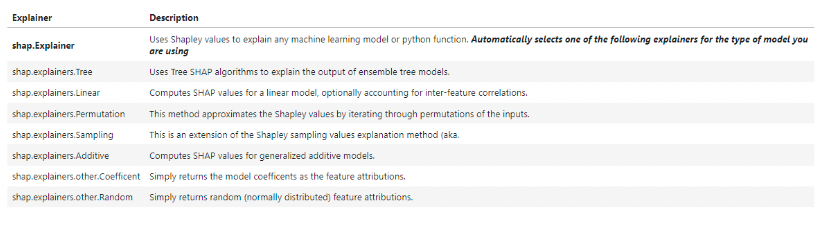

1. Create a SHAP explainer using your fit model



In [111]:
explainer = shap.Explainer(rf_clf)
explainer

- As we can see above, shap.Explainer recognized that we are using a tree based model, so it created a TreeExplainer.
- Now that we have the explainer, we need to provide then X and y data.
- The explainer will use a copy of our model to iterate through all of the features to calculate the marginal contribution of each feature to the model's predictions.
- These contributions will be represented as SHAP values, which we will interpret to explain our model.

## 2. Get SHAP values from explainer for your training data

In [112]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

## Important Note about SHAP Changes
- Recently, SHAP updated its functions to return a special class for SHAP values called Explanations as you can see when we checked the type above.
- Many of the examples in articles and tutorials on the internet are examples of the old way of using SHAP.
    - These approaches will still work, but they return simple NumPy arrays instead of the special Explanations class.
    - See the Examples in the Appendix for examples of the older approach.

First, let's remember the shape of the sample of X values we provided to our explainer.

In [113]:
X_shap.shape


(400, 43)

In [116]:
# As indicated by the output above, we have 400 samples (rows) 
# and 43 features (columns).

# Now let's investigate the shape of our shap_values:

shap_values.shape

(400, 43, 2)

- We can see that SHAP calculated values for all 400 rows and 43 columns in our X_shap dataset.
- The SHAP values also have a third dimension.
- Notice that the 3rd dimension is 2.
    - This is because our classification task has 2 classes. If we had more classes, we would have the same number in our third dimension as we have classes.
    - We actually have two SHAP values for every sample and feature (one for each target class)

Let's take a look at the first entry for SHAP values:

## Exploring SHAP Explanation Values
- What does the first row of SHAP values look like?
- This is the result for just one sample (in our case, one student) from our dataset.

In [117]:
shap_values[0]

.values =
array([[-1.15165368e-02,  1.15165368e-02],
       [-2.00970183e-02,  2.00970183e-02],
       [-3.73278511e-02,  3.73278511e-02],
       [-1.30577180e-02,  1.30577180e-02],
       [-6.02032650e-02,  6.02032650e-02],
       [ 1.82659012e-02, -1.82659012e-02],
       [-2.60672307e-02,  2.60672307e-02],
       [-5.23592261e-03,  5.23592261e-03],
       [-1.03872516e-02,  1.03872516e-02],
       [-2.83196172e-02,  2.83196172e-02],
       [-2.07484363e-02,  2.07484363e-02],
       [-5.73616057e-03,  5.73616057e-03],
       [-1.13086674e-02,  1.13086674e-02],
       [-4.39675434e-02,  4.39675434e-02],
       [-3.55386270e-02,  3.55386270e-02],
       [ 1.27171520e-03, -1.27171520e-03],
       [-5.32930678e-03,  5.32930678e-03],
       [-2.30715695e-03,  2.30715695e-03],
       [-4.69512766e-02,  4.69512766e-02],
       [-1.45327285e-03,  1.45327285e-03],
       [-5.67660591e-03,  5.67660591e-03],
       [-3.72593331e-04,  3.72593331e-04],
       [-2.87157566e-03,  2.87157566e-03],
 

Each entry in the shap_values array is a new type of object called an Explanation.
Each Explanation has:
values:
the SHAP values calculated for this observation/row.
for classification models, there is a column with values for each target.
base_values:
the baseline SHAP value without features, (you can think of this similar to an intercept).
For regression, it is the mean of all the y values in the training set and can be found with y_train.mean()
For classification, it is the mean of the predicted probability (.predict_proba) of the original X_train. There will be 1 probability for each class.
data:
the original input features

## Limiting our SHAP Values to one class
We have a set of SHAP values for each of our 2 target classes, so we need to decide which class we want to explain. Since our stakeholders have been interested in predicting and understanding students who fail, we can simplify our third dimension to just include the SHAP values for 1 (failing).

- Since the 3rd dimension of our SHAP explanations is the target class (Failing is index 1), we will want to slice out all rows, all columns, and index=1 for the final dimension.
    - shap_values[:,:,1]

In [118]:
## Brenda: which name to use?
# shap_vals_fail = shap_values[:,:,1]
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 43)

This greatly simplifies our outcome because now we only have two dimensions: our familiar rows and columns.

We now have only one SHAP value for every sample for each feature.

We can clearly view all of the values in a DataFrame:

In [119]:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,school_MS,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other,schoolsup_yes,famsup_yes,paid_yes,activities_yes,nursery_yes,higher_yes,internet_yes,romantic_yes
0,0.011517,0.020097,0.037328,0.013058,0.060203,-0.018266,0.026067,0.005236,0.010387,0.028320,0.020748,0.005736,0.011309,0.043968,0.035539,-0.001272,0.005329,0.002307,0.046951,0.001453,0.005677,0.000373,0.002872,-0.000225,0.000057,-0.001143,0.000815,0.005247,0.015226,0.004208,-0.001029,0.007523,0.000662,0.001909,0.000386,-0.001690,0.007628,-0.000286,0.002959,-0.001125,-0.010127,-0.000757,-0.001594
1,-0.027303,-0.009091,-0.031383,-0.010162,0.049549,-0.033083,-0.014626,-0.004118,0.003253,-0.031235,0.004435,0.017833,-0.049344,-0.040682,0.025022,-0.011379,-0.003799,0.002595,-0.017070,-0.035362,-0.001404,-0.003323,-0.007938,-0.001239,-0.001395,-0.010251,-0.006474,0.003280,-0.015919,-0.028659,-0.004538,0.004828,-0.003888,-0.007049,0.000052,-0.006882,0.005054,-0.004694,-0.004045,-0.008982,-0.023219,-0.001126,-0.002661
2,0.017169,0.032987,0.019626,-0.015481,0.007520,-0.026687,-0.007202,0.025579,0.040698,-0.015929,0.001173,0.003841,0.025080,0.080948,-0.011251,0.038092,0.007363,0.001380,-0.007668,0.002596,-0.005117,0.001234,0.003561,-0.000647,-0.000297,0.021454,0.013906,0.004540,0.027574,0.004750,-0.001471,0.007297,0.004914,0.005234,-0.000168,-0.001349,0.007637,-0.000833,0.007627,0.004793,-0.014682,0.000407,-0.006618
3,0.001809,-0.001358,-0.001983,0.008710,-0.099199,-0.034132,-0.010260,-0.004445,-0.006709,-0.023644,-0.010326,-0.008269,0.007948,0.008614,-0.017645,-0.004299,-0.001429,0.001784,-0.011344,0.001983,-0.005672,-0.001386,-0.000014,-0.000376,-0.001226,0.005254,0.002630,0.001950,-0.022413,-0.033509,-0.004206,-0.005627,-0.008104,-0.006877,-0.001257,0.010184,-0.002114,-0.001120,0.000369,-0.008371,-0.018657,-0.017193,0.005509
4,0.023117,0.035304,0.043111,0.002672,-0.006079,-0.025589,0.000259,0.027685,-0.012348,-0.006155,-0.003187,0.038435,0.014096,-0.001177,0.052577,-0.004504,-0.000448,0.004517,-0.001922,0.003276,0.005726,0.001250,0.002838,0.000213,-0.000518,0.014882,0.004071,0.003847,-0.005173,0.007281,-0.000556,-0.010176,0.011737,0.022177,-0.000538,-0.005201,0.006749,-0.001681,0.017924,-0.002532,-0.014325,0.000894,0.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.005944,0.032713,0.010837,0.017512,0.015403,-0.029194,-0.008268,0.002200,0.033450,-0.012353,-0.001753,0.003920,-0.033018,0.076793,-0.018266,0.044056,0.004954,0.003984,0.049728,0.004451,0.009985,0.006397,0.003805,-0.000098,0.000057,0.006940,0.001221,0.003836,0.026492,0.006006,-0.000313,0.004812,0.004523,0.001943,-0.000272,-0.002883,0.011984,-0.000758,-0.000626,0.000846,-0.015745,-0.000426,-0.005350
396,-0.032286,0.007996,-0.006788,-0.004848,-0.028363,-0.036994,-0.019997,0.003082,-0.010410,-0.025484,-0.019203,0.013089,0.035533,-0.035958,-0.025918,-0.019437,-0.001882,0.002458,-0.013930,0.003163,-0.018483,-0.005339,0.000345,-0.000950,-0.000626,0.001183,-0.000436,0.001897,0.004315,-0.002029,-0.001586,0.007717,-0.001411,-0.002327,-0.001202,-0.006209,-0.004485,-0.001636,-0.002966,-0.009947,-0.019903,-0.008036,-0.018128
397,0.022906,0.043701,0.045876,0.008123,0.065592,-0.020319,-0.007152,0.059772,-0.015232,-0.008339,0.005327,0.051061,0.011300,-0.023666,0.002258,0.000582,0.002345,-0.000007,-0.007452,0.003360,0.000645,0.002900,0.001926,0.000280,-0.000540,0.003650,0.005691,0.002209,0.004935,-0.011772,-0.001979,0.011892,0.000771,0.002492,0.000673,-0.003171,-0.004975,-0.000165,0.010768,-0.001453,-0.016682,0.001947,0.013505
398,0.011959,0.013783,0.016340,-0.002397,-0.047356,-0.021644,0.065

## SHAP Summary Plots for Global Explanations

Now that we have our SHAP values, we are ready to start exploring SHAP visualizations! The first type of plot we will explore is the summary plot. We will look at two versions: bar and dot.

## Summary Plot - Bar
- First, let's examine a simple version of our SHAP values.
    - By using the plot_type="bar" version of the summary plot, we get something that looks very similar to the feature importances we discussed previously.
    - The bar plot summary shows the average of the SHAP value for each feature across all samples.

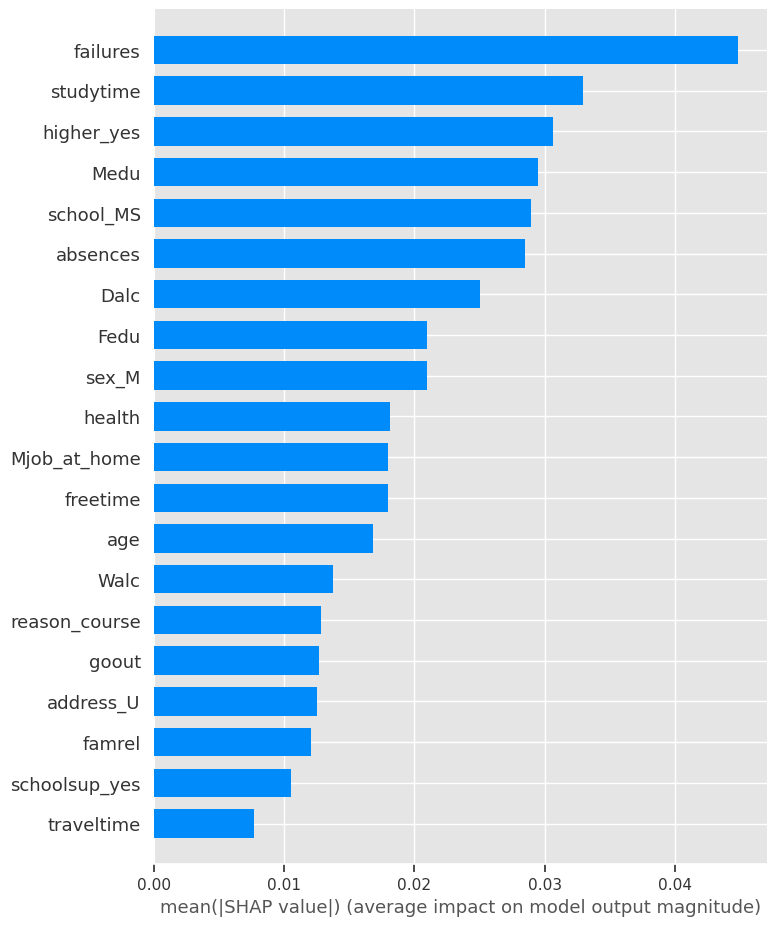

In [120]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')


- In this case, it is using the magnitude of the average SHAP values to to show which features had the biggest impact on the model's predictions.
- Based on the summary plot above, failures in other courses was the most important feature for predicting failing in Portuguese. Next was study time, and higher_yes.
- Let's remind ourselves what our random forest calculated as the feature importances, and compare the results.

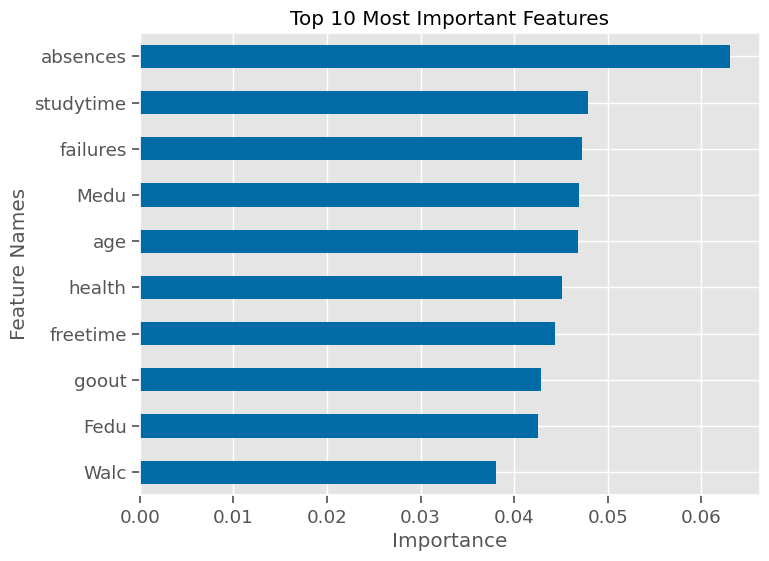

In [121]:
plot_importance(rf_importances,top_n=10);


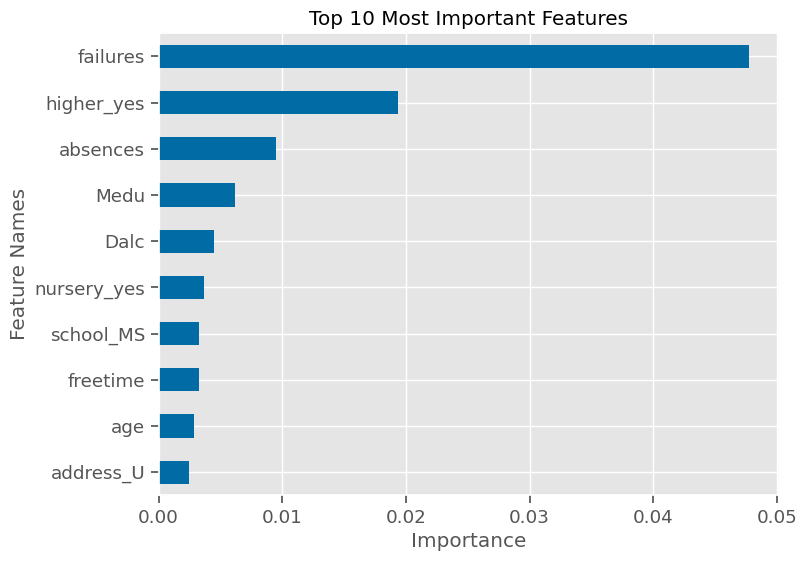

In [122]:
# Let's also remind ourselves of the permutation importances we calculated for the model.

plot_importance(rf_perm_importances,top_n=10);

- As we can see above, SHAP's importances differ from the built-in random forest importances.
- It is also different from the permutation importances. However, the permutation importances and SHAP importances shared similar important features that were undervalued by the random forest (e.g. higher_yes).
- Like feature importance and permutation importance, this visualization is not indicating which direction the features push the prediction.
- Let's remove the plot_type='bar' argument and examine the default plot type that will provide this information.

## Summary Plot - dot (default)
- Now, let's examine the "dot" version of the summary plot.
- By removing the plot_type argument, we are using the default, which is "dot".
    - Alternately, we could explicitly specify plot_type="dot".
        - There are also additional plot types that we will not be discussing in this lesson (e.g. "violin","compact_dot")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


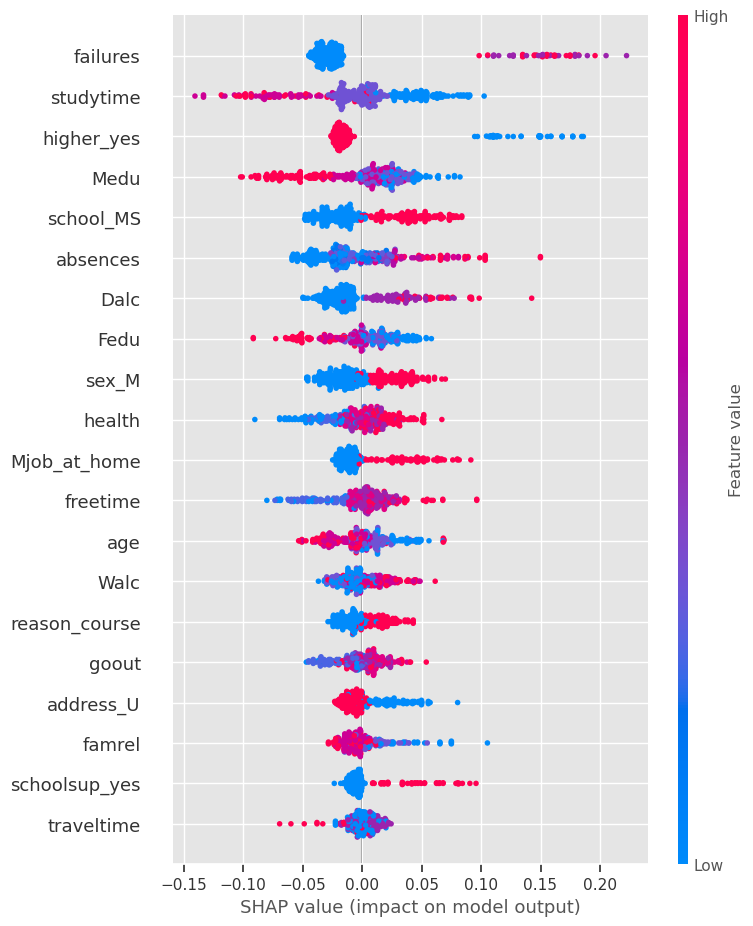

In [123]:
shap.summary_plot(shap_vals_1,X_shap)

Now THAT is a lot more nuanced of a visualization! Let's break down how to interpret the visual above.

Reading SHAP Summary Plots

In the summary plot above:
Each dot represents an observation/row (in this case, a student).
The features are plotted on the y-axis and are sorted from the most impactful features to the least (from top to bottom).
The calculated Shapley values for each observation are plotted on the x-axis. The more positive the value, the more the feature pushed the model's prediction towards predicting the current class (failing).
For each feature, the original values of that feature are represented with color.
Using the default colormap, blue represents the lowest value in the column and red represents the highest.
For one hot encoded categories, blue=0, red = 1.
For numeric features: the shade of the color indicates where it falls in the feature's distribution.
Let's just follow the red dots for each feature. Red means the feature value is higher.
If the red is on the right (positive), higher values of this feature increase the chance the prediction will be fail.
If the red is on the left (negative), higher values of this feature decrease the chances the prediction will be fail.
A quick glance above shows that failures and higher_yes are both very important, but they have opposite impacts. According to our model, higher values for failures increases the chance of failing Portuguese, whereas, higher values for higher_yes (1 since it is categorical) decreases the chance of failing.

It can take a bit of time to acclimate to this graph. Let's talk through some examples in detail.

### Interpreting the SHAP values for our model:
failures



Failures had the largest effect on the model's predictions (since it was the first bar at the top of the graph).

- Because red values are on the right (positive), we can see that the greater the number of failures a student had, the more likely the model would predict the student will Fail.
- We can see that having a high number of failures pushed the model's prediction heavily towards being a failure (as judged by how far to the right of the yaxis/0-line the red samples are located).
    - Notice that the blue dots (fewer failures) are only slightly to the left of the 0-line, indicating that the model is only slightly less likely to predict a failure, compared to the big impact of having a large number of failures.

studytime


Because the red dots are on the left (negative) we can see that the higher the study time, the less likely the model will predict the student will fail.

Important Note
Remember, our SHAP explanations and visualizations are explaining how our model was using the features and how they influenced the model's prediction.
It is not explaining the real-world situation. So always keep that in mind when interpreting SHAP visualizations.

## Summary
This lesson showed you how to obtain, visualize, and interpret SHAP values. SHAP's explanations provide a much more detailed and nuanced perspective on how our model is making its predictions. While the summary plots can be a little tricky to read at first, with just a little practice, you should find it much easier.


Additional Resources
Technical Papers
White Paper on Shapely Values: Lundberg & Lee 2017
White Paper from Nature Machine Learning: Lundberg et al 2020
Book Excerpts and Blogs
Intepretable Machine Learning Book - Section on SHAP
Towards Data Science Blog Posts:
Explain Your Model with SHAP Values
Explain Any Model with SHAP KernelExplaibner
https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
Videos/Talks:
Explaining Machine Learning Models (in general).
"Open the Black Box: an intro to Model Interpretability with LIME and SHAP
Understanding Shapely/SHAP Values:
AI Simplified: SHAP Values in Machine Learning - (Intuitive Explanation)
Explainable AI explained! | #4 SHAP - (Math Calculation Explanation)